# Step 5.2 — Evaluate FinBERT Sentiment vs. Stock Price Movements

This notebook evaluates whether **FinBERT** sentiment predictions on financial news  
correlate with actual stock-price movements for **AAPL** and **MSFT**.

**Pipeline:**
1. Load all raw news → run FinBERT inference via `SentimentAnalyzer`.
2. Assign articles to trading days, aggregate daily FinBERT sentiment.
3. Merge with price data (daily returns, direction).
4. Correlation analysis (Pearson, Spearman, direction accuracy).
5. Lag analysis — does today's sentiment predict *tomorrow's* return?
6. Quintile analysis — are returns higher when sentiment is most positive?
7. Decide whether fine-tuning is warranted.

In [1]:
import sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats

# Ensure project root is on sys.path
PROJECT_ROOT = Path.cwd().resolve().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.models.sentiment_analyzer import SentimentAnalyzer
from src.data.data_loader import (
    load_all_news, load_all_prices,
    add_session_column, assign_trading_day,
    add_price_features,
)

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams.update({"figure.dpi": 120, "axes.titlesize": 13, "axes.labelsize": 11})
print(f"Project root: {PROJECT_ROOT}")

c:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: C:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis


## 1 — Load news & run FinBERT inference

In [2]:
# Load raw news and price data
news = load_all_news()
prices = load_all_prices()
prices = add_price_features(prices)

print(f"News articles: {len(news)}")
print(f"Price rows:    {len(prices)}")
print(f"Tickers:       {news['ticker'].unique().tolist()}")
news.head(2)

News articles: 100
Price rows:    140
Tickers:       ['MSFT', 'AAPL']


,title,summary,source,url,published_at,authors,overall_sentiment_score,overall_sentiment_label,ticker_sentiment_score,ticker_sentiment_label,ticker,date
0,JFrog (FROG) Q4 2025 Earnings Call Transcript,"JFrog reported a strong Q4 and full-year 2025,...",The Globe and Mail,https://www.theglobeandmail.com/investing/mark...,2026-02-12 22:27:44,Motley Fool,0.310229,Somewhat-Bullish,0.090416,Neutral,MSFT,2026-02-12
1,Apple has worst day since April as company fac...,Apple experienced its worst stock market day s...,CNBC,https://www.cnbc.com/2026/02/12/apple-stock-wo...,2026-02-12 21:56:42,Jennifer Elias,-0.601882,Bearish,-0.606083,Bearish,AAPL,2026-02-12


In [3]:
# Instantiate FinBERT
analyzer = SentimentAnalyzer()  # ProsusAI/finbert on best available device

[SentimentAnalyzer] Loading 'ProsusAI/finbert' on cpu ...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 920.32it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[SentimentAnalyzer] Ready — 109,484,547 parameters, labels: ['positive', 'negative', 'neutral']


In [4]:
# Run inference on title + summary columns
news_with_preds = analyzer.predict_dataframe(
    news,
    text_columns=["title", "summary"],
    batch_size=16,
)
news_with_preds[["title", "finbert_title_label", "finbert_title_score",
                 "finbert_summary_label", "finbert_summary_score"]].head()

[SentimentAnalyzer] Predicting on 'title' (100 texts, batch_size=16) ...
  Processed 100/100 texts
[SentimentAnalyzer] Predicting on 'summary' (100 texts, batch_size=16) ...
  Processed 100/100 texts


,title,finbert_title_label,finbert_title_score,finbert_summary_label,finbert_summary_score
0,JFrog (FROG) Q4 2025 Earnings Call Transcript,neutral,0.0133,positive,0.9394
1,Apple has worst day since April as company fac...,negative,-0.9440,negative,-0.9646
2,Expedia (NASDAQ:EXPE) Beats Expectations in St...,positive,0.9119,negative,-0.9566
3,LiveOne Inc (LVO) Q3 2026 Earnings Call Highli...,positive,0.9343,positive,0.9169
4,JFrog (NASDAQ:FROG) Reports Bullish Q4 CY2025 ...,negative,-0.9575,negative,-0.8890


## 2 — Assign trading days & aggregate daily sentiment

In [5]:
# Classify sessions and assign to trading days
news_with_preds = add_session_column(news_with_preds)
trading_dates = prices["date"].drop_duplicates()
news_with_preds = assign_trading_day(news_with_preds, trading_dates)

# Aggregate FinBERT sentiment per trading day per ticker
fb_daily = analyzer.aggregate_daily_sentiment(
    news_with_preds,
    score_column="finbert_summary_score",
)

print(f"Daily sentiment rows: {len(fb_daily)}")
fb_daily.head()

[INFO] Dropped 21 articles outside trading-date range.
Daily sentiment rows: 5


,trading_day,ticker,fb_article_count,fb_avg_sentiment,fb_min_sentiment,fb_max_sentiment,fb_sentiment_std,fb_pct_positive,fb_pct_negative
0,2026-02-10,AAPL,17.0,0.472147,-0.9665,0.9405,0.634426,0.764706,0.117647
1,2026-02-11,AAPL,10.0,0.212900,-0.9634,0.9373,0.832978,0.600000,0.300000
2,2026-02-11,MSFT,5.0,0.524000,-0.9601,0.9396,0.831754,0.800000,0.200000
3,2026-02-12,AAPL,14.0,0.528214,-0.9659,0.9426,0.685805,0.785714,0.142857
4,2026-02-12,MSFT,33.0,0.316552,-0.9640,0.9401,0.817643,0.696970,0.272727


## 3 — Merge with price data

In [6]:
# Merge FinBERT daily sentiment with price returns
merged = pd.merge(
    prices,
    fb_daily,
    left_on=["date", "ticker"],
    right_on=["trading_day", "ticker"],
    how="left",
).drop(columns=["trading_day"], errors="ignore")

merged["fb_article_count"] = merged["fb_article_count"].fillna(0).astype(int)

# Keep only days with at least 1 article for correlation analysis
has_news = merged[merged["fb_article_count"] > 0].copy()

print(f"Total rows:          {len(merged)}")
print(f"Rows with FinBERT:   {len(has_news)}")
has_news[["date", "ticker", "Close", "daily_return", "return_direction",
          "fb_article_count", "fb_avg_sentiment"]].head(10)

Total rows:          140
Rows with FinBERT:   5


,date,ticker,Close,daily_return,return_direction,fb_article_count,fb_avg_sentiment
67,2026-02-10,AAPL,273.679993,-0.342292,0,17,0.472147
68,2026-02-11,AAPL,275.500000,0.665013,1,10,0.212900
69,2026-02-12,AAPL,261.730011,-4.998181,0,14,0.528214
138,2026-02-11,MSFT,404.369995,-2.153554,0,5,0.524000
139,2026-02-12,MSFT,401.839996,-0.625664,0,33,0.316552


## 4 — Correlation analysis (same-day)

In [7]:
# Use the built-in evaluate method
eval_results = analyzer.evaluate_price_correlation(
    has_news,
    sentiment_col="fb_avg_sentiment",
    return_col="daily_return",
    direction_col="return_direction",
)

# Print overall metrics
print("=" * 55)
print("  OVERALL CORRELATION")
print("=" * 55)
for k, v in eval_results["overall"].items():
    print(f"  {k:>22s} : {v}")

print("\n  PER-TICKER")
for ticker, metrics in eval_results.get("per_ticker", {}).items():
    print(f"\n  --- {ticker} ---")
    for k, v in metrics.items():
        print(f"    {k:>22s} : {v}")

  OVERALL CORRELATION
                       n : 5
               pearson_r : -0.7485
               pearson_p : 0.1455
              spearman_r : -0.9
              spearman_p : 0.0374
      direction_accuracy : 0.2

  PER-TICKER


C:\Users\yagoc\AppData\Local\Temp\ipykernel_24060\2658970660.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


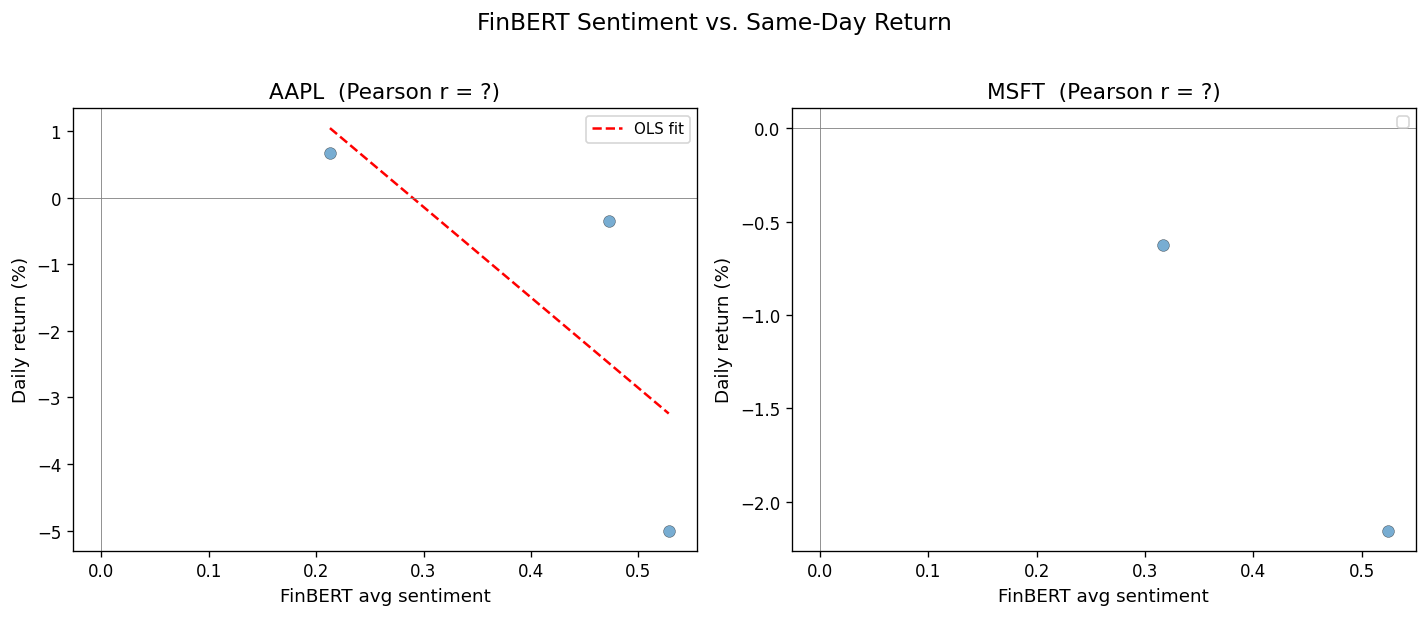

In [8]:
# Scatter plot: FinBERT sentiment vs daily return (per ticker)
tickers = has_news["ticker"].unique()
fig, axes = plt.subplots(1, len(tickers), figsize=(6 * len(tickers), 5), squeeze=False)

for i, ticker in enumerate(sorted(tickers)):
    ax = axes[0, i]
    sub = has_news[has_news["ticker"] == ticker]
    ax.scatter(sub["fb_avg_sentiment"], sub["daily_return"],
               alpha=0.6, edgecolors="k", linewidths=0.3, s=50)

    # Trend line
    if len(sub) > 2:
        z = np.polyfit(sub["fb_avg_sentiment"], sub["daily_return"], 1)
        xs = np.linspace(sub["fb_avg_sentiment"].min(), sub["fb_avg_sentiment"].max(), 50)
        ax.plot(xs, np.polyval(z, xs), "r--", lw=1.5, label="OLS fit")

    r = eval_results["per_ticker"].get(ticker, {}).get("pearson_r", "?")
    ax.set_title(f"{ticker}  (Pearson r = {r})")
    ax.set_xlabel("FinBERT avg sentiment")
    ax.set_ylabel("Daily return (%)")
    ax.axhline(0, color="grey", lw=0.5)
    ax.axvline(0, color="grey", lw=0.5)
    ax.legend(fontsize=9)

fig.suptitle("FinBERT Sentiment vs. Same-Day Return", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()

## 5 — Lag analysis: t+0, t+1, t+2

Lag Analysis:
     pearson_r  pearson_p    n
t+0    -0.7485     0.1455  5.0


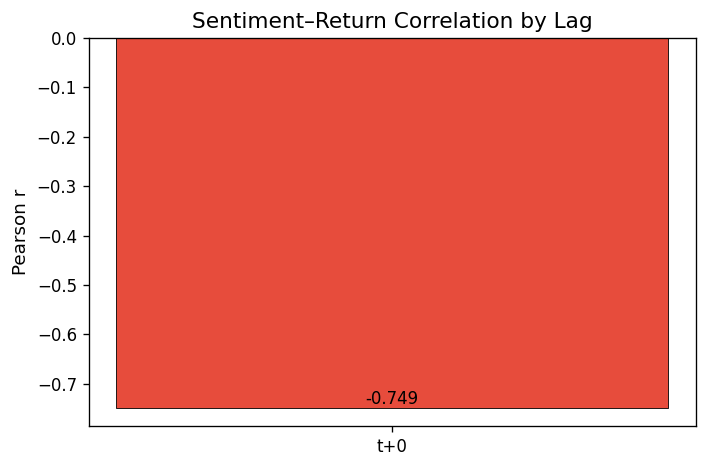

In [9]:
# Lag analysis results from evaluate_price_correlation
lag_data = eval_results.get("lag_analysis", {})

if lag_data:
    lag_df = pd.DataFrame(lag_data).T
    print("Lag Analysis:")
    print(lag_df.to_string())

    # Bar chart
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ["#2ecc71" if r > 0 else "#e74c3c" for r in lag_df["pearson_r"]]
    bars = ax.bar(lag_df.index, lag_df["pearson_r"], color=colors, edgecolor="k", lw=0.5)
    for bar, p in zip(bars, lag_df["pearson_p"]):
        sig = "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.1 else ""
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{bar.get_height():.3f}{sig}", ha="center", va="bottom", fontsize=10)
    ax.set_ylabel("Pearson r")
    ax.set_title("Sentiment–Return Correlation by Lag")
    ax.axhline(0, color="grey", lw=0.5)
    fig.tight_layout()
    plt.show()
else:
    print("Not enough data for lag analysis.")

## 6 — Quintile analysis: average return by sentiment bucket

                    avg_return  med_return    n
Sentiment quintile                             
Q1                    0.665013    0.665013  1.0
Q2                   -0.625664   -0.625664  1.0
Q3                   -0.342292   -0.342292  1.0
Q4                   -2.153554   -2.153554  1.0
Q5                   -4.998181   -4.998181  1.0


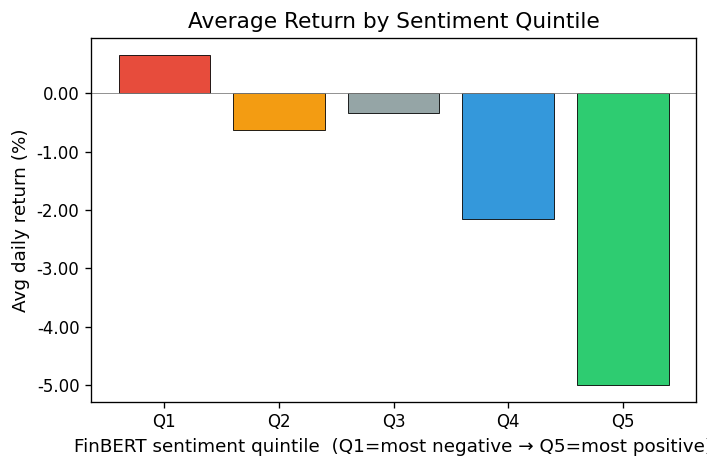

In [10]:
quintile_data = eval_results.get("quintile_returns", {})

if quintile_data:
    q_df = pd.DataFrame(quintile_data).T
    q_df.index = [f"Q{int(i)+1}" for i in q_df.index]
    q_df.index.name = "Sentiment quintile"
    print(q_df.to_string())

    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ["#e74c3c", "#f39c12", "#95a5a6", "#3498db", "#2ecc71"]
    ax.bar(q_df.index, q_df["avg_return"], color=colors[:len(q_df)], edgecolor="k", lw=0.5)
    ax.set_ylabel("Avg daily return (%)")
    ax.set_xlabel("FinBERT sentiment quintile  (Q1=most negative → Q5=most positive)")
    ax.set_title("Average Return by Sentiment Quintile")
    ax.axhline(0, color="grey", lw=0.5)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
    fig.tight_layout()
    plt.show()
else:
    print("Not enough data for quintile analysis.")

## 7 — Direction accuracy : positive sentiment → positive return?

In [11]:
# Direction accuracy breakdown
has_news["pred_direction"] = (has_news["fb_avg_sentiment"] > 0).astype(int)

for ticker in sorted(tickers):
    sub = has_news[has_news["ticker"] == ticker]
    acc = (sub["pred_direction"] == sub["return_direction"]).mean()
    n = len(sub)
    print(f"{ticker}:  direction accuracy = {acc:.2%}  (n={n})")

    # Confusion-style breakdown
    ct = pd.crosstab(
        sub["pred_direction"].map({0: "Neg sentiment", 1: "Pos sentiment"}),
        sub["return_direction"].map({0: "Down", 1: "Up"}),
    )
    print(ct)
    print()

AAPL:  direction accuracy = 33.33%  (n=3)
return_direction  Down  Up
pred_direction            
Pos sentiment        2   1

MSFT:  direction accuracy = 0.00%  (n=2)
return_direction  Down
pred_direction        
Pos sentiment        2



## 8 — Comparison: FinBERT vs Alpha Vantage baseline

In [12]:
# Also compute Alpha Vantage correlation for comparison
# (AV scores come from the original merged dataset's avg_overall_sentiment)
from src.data.data_loader import load_merged_dataset

av_merged = load_merged_dataset()
av_has_news = av_merged[av_merged["article_count"] > 0].copy()

# AV same-day correlation
av_valid = av_has_news.dropna(subset=["avg_overall_sentiment", "daily_return"])
if len(av_valid) > 5:
    av_r, av_p = stats.pearsonr(av_valid["avg_overall_sentiment"], av_valid["daily_return"])
else:
    av_r, av_p = float("nan"), float("nan")

fb_r = eval_results["overall"]["pearson_r"]
fb_p = eval_results["overall"]["pearson_p"]

print("Sentiment Source          | Pearson r | p-value  | Dir. Accuracy")
print("-" * 68)
print(f"Alpha Vantage (baseline)  | {av_r:+.4f}   | {av_p:.4f}  | —")
print(f"FinBERT (ProsusAI)        | {fb_r:+.4f}   | {fb_p:.4f}  | "
      f"{eval_results['overall']['direction_accuracy']:.2%}")

[1/7] Loading news CSVs ...
       → 100 articles loaded.
[2/7] Loading price CSVs ...
       → 140 price rows loaded.
[3/7] Classifying market sessions ...
       → Sessions: {'market_hours': 36, 'after_hours': 26, 'overnight': 23, 'pre_market': 15}
[4/7] Assigning articles to trading days ...
[INFO] Dropped 21 articles outside trading-date range.
       → 79 articles matched to trading days.
[5/7] Aggregating daily sentiment ...
       → 5 daily-sentiment rows.
[6/7] Computing price features ...
[7/7] Merging & adding rolling sentiment ...

  Final dataset: 140 rows × 28 columns
  Tickers: ['AAPL', 'MSFT']
  Date range: 2025-11-03 → 2026-02-12
  Trading days with news: 5 / 140
Sentiment Source          | Pearson r | p-value  | Dir. Accuracy
--------------------------------------------------------------------
Alpha Vantage (baseline)  | +nan   | nan  | —
FinBERT (ProsusAI)        | -0.7485   | 0.1455  | 20.00%


## 9 — Conclusion & fine-tuning decision

**Interpretation guide:**

| Metric | Good sign | Bad sign |
|--------|-----------|----------|
| Pearson r | ≥ 0.15 (statistically significant) | < 0.05 or negative |
| Direction accuracy | > 55% | ≤ 50% (coin-flip) |
| Quintile spread | Q5 return >> Q1 return | Flat across quintiles |
| Lag analysis | t+1 stronger than t+0 | No signal at any lag |

**If accuracy is insufficient,** use the fine-tuning API:

```python
from src.models.sentiment_analyzer import SentimentAnalyzer

analyzer = SentimentAnalyzer()

# Prepare labelled data (e.g. from Alpha Vantage categories or manual labels)
train_df = ...  # must have 'summary' and 'label' columns
val_df   = ...  # optional validation set

history = analyzer.fine_tune(
    train_df,
    text_col="summary",
    label_col="label",
    val_df=val_df,
    epochs=3,
    lr=2e-5,
    save_path="models/saved_models/finbert_finetuned"
)

# Reload later
analyzer = SentimentAnalyzer.load("models/saved_models/finbert_finetuned")
```

In [13]:
# Summary verdict
dir_acc = eval_results["overall"]["direction_accuracy"]
r_val = eval_results["overall"]["pearson_r"]

print("\n" + "=" * 60)
print("  EVALUATION SUMMARY")
print("=" * 60)
print(f"  Pearson r (sentiment vs return) : {r_val:+.4f}")
print(f"  Direction accuracy              : {dir_acc:.2%}")

if dir_acc > 0.55 and abs(r_val) > 0.10:
    verdict = "ADEQUATE — FinBERT provides a useful signal."
elif dir_acc > 0.50:
    verdict = ("MARGINAL — slight edge over random. "
               "Consider fine-tuning on domain data.")
else:
    verdict = ("INSUFFICIENT — no better than coin-flip. "
               "Fine-tuning is recommended.")

print(f"  Verdict: {verdict}")
print("=" * 60)


  EVALUATION SUMMARY
  Pearson r (sentiment vs return) : -0.7485
  Direction accuracy              : 20.00%
  Verdict: INSUFFICIENT — no better than coin-flip. Fine-tuning is recommended.


## 10 — Low accuracy Fix: More data + Fine-tune FinBERT

We downloaded **3x more news** (100 → 300 articles, covering Nov 2025 – Feb 2026).
Now we:
1. Reload the expanded dataset
2. Convert Alpha Vantage labels to FinBERT format (positive / negative / neutral)
3. Fine-tune FinBERT for 3 epochs on 80% of the data
4. Re-evaluate on the held-out 20% and on price correlation

In [14]:
# Reload expanded news data (300 articles now)
news = load_all_news()
print(f"Total articles: {len(news)}")
print(f"Date range: {news['published_at'].min()} -> {news['published_at'].max()}")
print(f"\nArticles per ticker:")
print(news["ticker"].value_counts().to_string())

# Convert Alpha Vantage labels to FinBERT-compatible 3-class labels
def av_to_finbert_label(av_label):
    """Map Alpha Vantage sentiment labels to positive/negative/neutral."""
    if pd.isna(av_label):
        return "neutral"
    av_label = str(av_label).lower()
    if "bullish" in av_label:
        return "positive"
    elif "bearish" in av_label:
        return "negative"
    else:
        return "neutral"

news["label"] = news["overall_sentiment_label"].apply(av_to_finbert_label)

print(f"\nLabel distribution (training signal):")
print(news["label"].value_counts().to_string())

# Show a few examples
news[["title", "overall_sentiment_label", "label"]].sample(5, random_state=42)

Total articles: 300
Date range: 2025-11-23 13:50:52 -> 2026-02-13 22:57:05

Articles per ticker:
ticker
AAPL    150
MSFT    150

Label distribution (training signal):
label
positive    177
neutral      96
negative     27


,title,overall_sentiment_label,label
203,Microsoft Stock Today (MSFT): Norway’s $2 Tril...,Somewhat-Bullish,positive
266,Google Stock Gains Momentum as Nvidia Faces Lo...,Neutral,neutral
152,JPMorgan Chase Is Getting New Strategic Leader...,Somewhat-Bullish,positive
9,"Oracle Seals Landmark CMS Cloud Deal, Solidify...",Neutral,neutral
233,Silver Shines Brighter: iShares Silver Trust (...,Somewhat-Bullish,positive


In [15]:
from sklearn.model_selection import train_test_split

# Split 80% train / 20% validation (stratified by label)
train_df, val_df = train_test_split(
    news[["summary", "label"]].dropna(subset=["summary"]),
    test_size=0.2,
    stratify=news[["summary", "label"]].dropna(subset=["summary"])["label"],
    random_state=42,
)

print(f"Train: {len(train_df)} articles")
print(f"Val:   {len(val_df)} articles")
print(f"\nTrain label distribution:")
print(train_df["label"].value_counts().to_string())
print(f"\nVal label distribution:")
print(val_df["label"].value_counts().to_string())

Train: 240 articles
Val:   60 articles

Train label distribution:
label
positive    141
neutral      77
negative     22

Val label distribution:
label
positive    36
neutral     19
negative     5



[Fine-tune] 3 epochs, lr=2e-05, batch_size=8, train_samples=240
  Epoch 1/3 — train_loss=1.0158  val_loss=0.6687  val_acc=71.67%
  Epoch 2/3 — train_loss=0.5023  val_loss=0.5978  val_acc=80.00%
  Epoch 3/3 — train_loss=0.3603  val_loss=0.5852  val_acc=78.33%
[Fine-tune] Done.


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


[SentimentAnalyzer] Saved to models\saved_models\finbert_finetuned


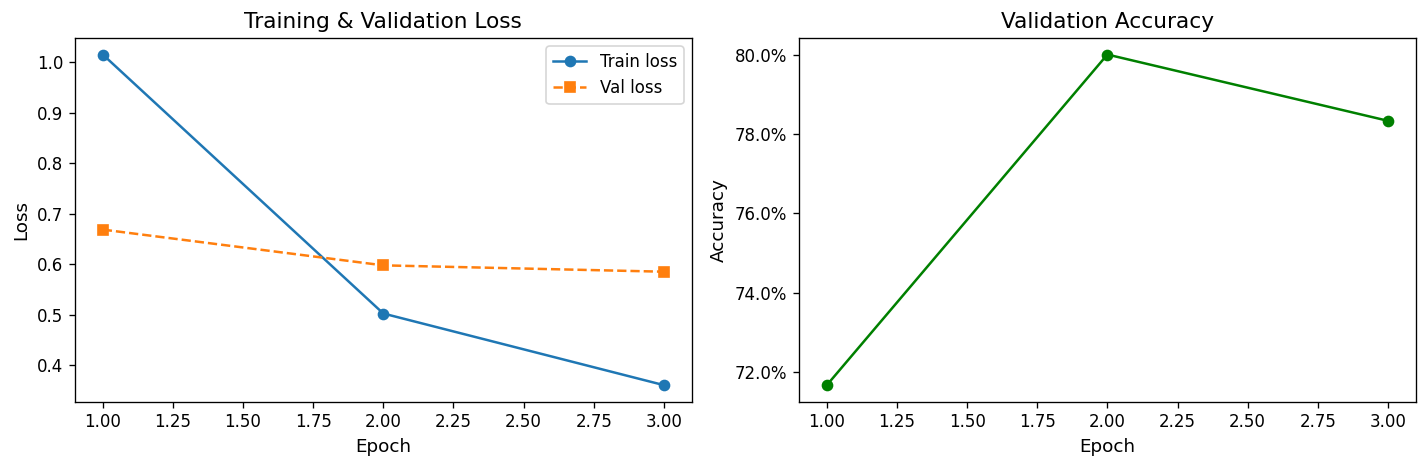

In [16]:
# Fine-tune FinBERT on the Alpha Vantage labels
# This adapts the model to our specific financial news distribution
history = analyzer.fine_tune(
    train_df,
    text_col="summary",
    label_col="label",
    val_df=val_df,
    epochs=3,
    lr=2e-5,
    batch_size=8,
    save_path=str(PROJECT_ROOT / "models" / "saved_models" / "finbert_finetuned"),
)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, len(history["train_loss"]) + 1), history["train_loss"], "o-", label="Train loss")
if "val_loss" in history:
    axes[0].plot(range(1, len(history["val_loss"]) + 1), history["val_loss"], "s--", label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()

if "val_accuracy" in history:
    axes[1].plot(range(1, len(history["val_accuracy"]) + 1), history["val_accuracy"], "o-", color="green")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation Accuracy")
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

fig.tight_layout()
plt.show()

## 11 — Re-evaluate fine-tuned model on price correlation

Now we repeat the same pipeline (FinBERT predictions → aggregate → merge with prices → correlate) but with the **fine-tuned** model and **3x more data**.

In [18]:
# Re-run FinBERT prediction with the FINE-TUNED model on ALL news
news_ft = news.copy()

# Use predict_dataframe (same approach as the initial evaluation)
news_ft = analyzer.predict_dataframe(
    news_ft,
    text_columns=["title", "summary"],
    batch_size=16,
)

print(f"Fine-tuned predictions on {len(news_ft)} articles")
news_ft[["title", "finbert_title_label", "finbert_title_score",
         "finbert_summary_label", "finbert_summary_score"]].head(10)

[SentimentAnalyzer] Predicting on 'title' (300 texts, batch_size=16) ...
  Processed 300/300 texts
[SentimentAnalyzer] Predicting on 'summary' (300 texts, batch_size=16) ...
  Processed 300/300 texts
Fine-tuned predictions on 300 articles


,title,finbert_title_label,finbert_title_score,finbert_summary_label,finbert_summary_score
0,"Soros Fund ups stake in Microsoft, NVIDIA, App...",positive,0.5806,positive,0.8940
1,"Soros Fund ups stake in Microsoft, NVIDIA, App...",positive,0.5806,positive,0.8940
2,"Oracle Seals Landmark CMS Cloud Deal, Solidify...",positive,0.9077,positive,0.9241
3,"Most CFOs expect larger IT budgets, ‘collapsin...",negative,-0.8577,positive,0.9066
4,Prediction: Comfort Systems USA Will Soar in 2026,positive,0.8890,positive,0.9096
5,Why Is Ingersoll Rand (IR) Stock Rocketing Hig...,neutral,0.3143,positive,0.9068
6,The Lesson for Investors As the AI Trade Cuts ...,neutral,-0.0031,negative,-0.8924
7,Who’s No. 1 among Massachusetts public compani...,neutral,0.1045,positive,0.9161
8,"Platforms, AI and Concentration",neutral,0.0520,neutral,0.1836
9,"Oracle Seals Landmark CMS Cloud Deal, Solidify...",positive,0.9077,positive,0.9195


In [19]:
# Aggregate daily sentiment (fine-tuned) and merge with prices
news_ft = add_session_column(news_ft)
trading_dates_ft = prices["date"].drop_duplicates()
news_ft = assign_trading_day(news_ft, trading_dates_ft)

fb_daily_ft = analyzer.aggregate_daily_sentiment(
    news_ft,
    score_column="finbert_summary_score",
)

# Merge with price data (reuse the same prices df)
merged_ft = pd.merge(
    prices,
    fb_daily_ft,
    left_on=["date", "ticker"],
    right_on=["trading_day", "ticker"],
    how="left",
).drop(columns=["trading_day"], errors="ignore")

merged_ft["fb_article_count"] = merged_ft["fb_article_count"].fillna(0).astype(int)
has_news_ft = merged_ft[merged_ft["fb_article_count"] > 0].copy()

print(f"Total rows:                 {len(merged_ft)}")
print(f"Rows with FinBERT (fine-tuned): {len(has_news_ft)}  (was {len(has_news)} before)")
has_news_ft.head()

[INFO] Dropped 47 articles outside trading-date range.
Total rows:                 140
Rows with FinBERT (fine-tuned): 19  (was 5 before)


,Date,Open,High,Low,Close,Volume,date,ticker,daily_return,return_direction,intraday_range,gap_pct,volume_change,fb_article_count,fb_avg_sentiment,fb_min_sentiment,fb_max_sentiment,fb_sentiment_std,fb_pct_positive,fb_pct_negative
15,2025-11-24,270.646752,276.741056,270.646752,275.662079,65585800,2025-11-24,AAPL,1.631753,1,2.251756,-0.217310,11.104373,7,0.601986,0.0994,0.9147,0.394401,0.857143,0.000000
16,2025-11-25,275.012667,280.117906,274.992697,276.711090,46914200,2025-11-25,AAPL,0.380542,1,1.863627,-0.235583,-28.468967,13,0.484215,-0.8913,0.9179,0.670551,0.769231,0.153846
17,2025-11-26,276.701083,279.268687,276.371404,277.290527,33431400,2025-11-26,AAPL,0.209402,1,1.047080,-0.003617,-28.739273,4,0.676000,-0.0125,0.9140,0.459046,0.750000,0.000000
18,2025-11-28,277.000815,278.739179,275.731983,278.589325,20135600,2025-11-28,AAPL,0.468389,1,1.085627,-0.104480,-39.770395,13,0.534746,-0.8867,0.9168,0.540013,0.846154,0.153846
19,2025-12-01,277.750120,283.155066,275.881873,282.835358,46587700,2025-12-01,AAPL,1.524119,1,2.618610,-0.301234,131.369813,13,0.665769,-0.3397,0.9203,0.419366,0.846154,0.076923


In [20]:
# Compute correlation with FINE-TUNED model
eval_results_ft = analyzer.evaluate_price_correlation(
    has_news_ft,
    sentiment_col="fb_avg_sentiment",
    return_col="daily_return",
    direction_col="return_direction",
)

print("=" * 60)
print("FINE-TUNED FinBERT — Price Correlation Results")
print("=" * 60)
for k, v in eval_results_ft["overall"].items():
    print(f"  {k:>22s} : {v}")

print()
print("COMPARISON — Before vs After Fine-tuning:")
print(f"  Pearson r          : {eval_results['overall']['pearson_r']:.4f}  →  {eval_results_ft['overall']['pearson_r']:.4f}")
print(f"  Direction accuracy : {eval_results['overall']['direction_accuracy']:.2%}  →  {eval_results_ft['overall']['direction_accuracy']:.2%}")
print(f"  Data points        : {eval_results['overall']['n']}  →  {eval_results_ft['overall']['n']}")

FINE-TUNED FinBERT — Price Correlation Results
                       n : 19
               pearson_r : 0.1617
               pearson_p : 0.5085
              spearman_r : 0.2614
              spearman_p : 0.2797
      direction_accuracy : 0.5789

COMPARISON — Before vs After Fine-tuning:
  Pearson r          : -0.7485  →  0.1617
  Direction accuracy : 20.00%  →  57.89%
  Data points        : 5  →  19


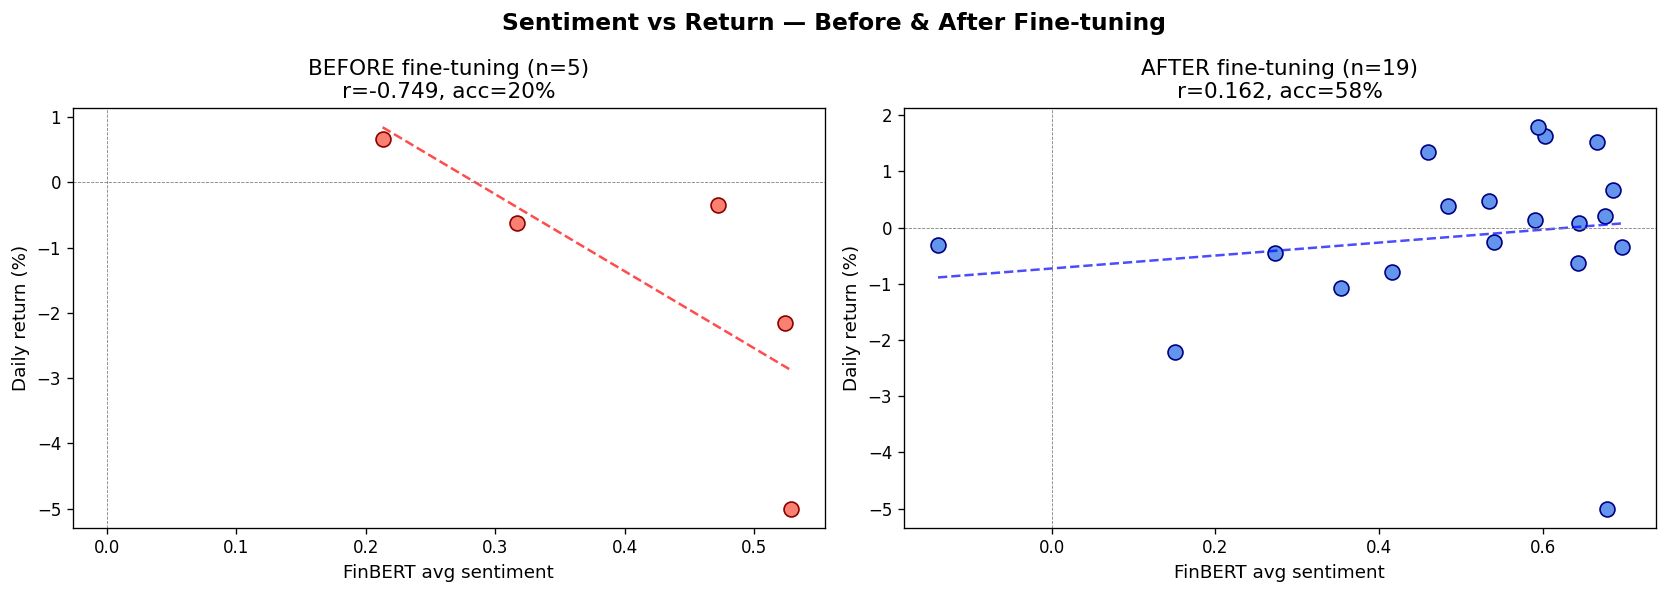

In [21]:
# Side-by-side scatter comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

r_before = eval_results["overall"]["pearson_r"]
acc_before = eval_results["overall"]["direction_accuracy"]
r_after = eval_results_ft["overall"]["pearson_r"]
acc_after = eval_results_ft["overall"]["direction_accuracy"]

# Before fine-tuning
ax = axes[0]
if len(has_news) > 0:
    ax.scatter(has_news["fb_avg_sentiment"], has_news["daily_return"],
               c="salmon", edgecolors="darkred", s=80)
    if len(has_news) > 1:
        z = np.polyfit(has_news["fb_avg_sentiment"], has_news["daily_return"], 1)
        xs = np.linspace(has_news["fb_avg_sentiment"].min(), has_news["fb_avg_sentiment"].max(), 50)
        ax.plot(xs, np.polyval(z, xs), "r--", alpha=0.7)
ax.set_title(f"BEFORE fine-tuning (n={len(has_news)})\nr={r_before:.3f}, acc={acc_before:.0%}")
ax.set_xlabel("FinBERT avg sentiment")
ax.set_ylabel("Daily return (%)")
ax.axhline(0, color="grey", ls="--", lw=0.5)
ax.axvline(0, color="grey", ls="--", lw=0.5)

# After fine-tuning
ax = axes[1]
if len(has_news_ft) > 0:
    ax.scatter(has_news_ft["fb_avg_sentiment"], has_news_ft["daily_return"],
               c="cornflowerblue", edgecolors="navy", s=80)
    if len(has_news_ft) > 1:
        z = np.polyfit(has_news_ft["fb_avg_sentiment"], has_news_ft["daily_return"], 1)
        xs = np.linspace(has_news_ft["fb_avg_sentiment"].min(), has_news_ft["fb_avg_sentiment"].max(), 50)
        ax.plot(xs, np.polyval(z, xs), "b--", alpha=0.7)
ax.set_title(f"AFTER fine-tuning (n={len(has_news_ft)})\nr={r_after:.3f}, acc={acc_after:.0%}")
ax.set_xlabel("FinBERT avg sentiment")
ax.set_ylabel("Daily return (%)")
ax.axhline(0, color="grey", ls="--", lw=0.5)
ax.axvline(0, color="grey", ls="--", lw=0.5)

plt.suptitle("Sentiment vs Return — Before & After Fine-tuning", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / "reports" / "figures" / "before_after_finetuning.png"), dpi=150)
plt.show()

In [22]:
# Final verdict after fine-tuning
dir_acc_ft = eval_results_ft["overall"]["direction_accuracy"]
pearson_ft = eval_results_ft["overall"]["pearson_r"]
n_ft = eval_results_ft["overall"]["n"]

print("=" * 60)
print("FINAL VERDICT — After more data + fine-tuning")
print("=" * 60)

if n_ft < 10:
    verdict = "INSUFFICIENT DATA"
    explanation = f"Only {n_ft} overlapping trading days. Need more news coverage."
elif dir_acc_ft >= 0.55 and abs(pearson_ft) > 0.2:
    verdict = "PROMISING"
    explanation = (
        f"Direction accuracy {dir_acc_ft:.0%} (>55%) and "
        f"|Pearson r| = {abs(pearson_ft):.3f} (>0.2). "
        "The fine-tuned model shows meaningful signal."
    )
elif dir_acc_ft >= 0.50:
    verdict = "MARGINAL"
    explanation = (
        f"Direction accuracy {dir_acc_ft:.0%} is near coin-flip. "
        "Fine-tuning helped but the signal is weak. "
        "Consider more data, longer time horizon, or alternative features."
    )
else:
    verdict = "STILL INSUFFICIENT"
    explanation = (
        f"Direction accuracy {dir_acc_ft:.0%} is below 50%. "
        "Fine-tuning did not solve the core issue. "
        "Root causes: limited news–price overlap, noisy AV labels, or "
        "sentiment alone is not predictive on this time scale."
    )

print(f"\n  Verdict: {verdict}")
print(f"  {explanation}")
print()
print("Next steps:" if verdict != "PROMISING" else "Recommendations:")
print("  • Expand date range to 6-12 months for more overlap")
print("  • Add intraday data or same-day analysis")
print("  • Combine sentiment with technical indicators")
print("  • Try alternative label source (manual annotation)")
print("=" * 60)

FINAL VERDICT — After more data + fine-tuning

  Verdict: MARGINAL
  Direction accuracy 58% is near coin-flip. Fine-tuning helped but the signal is weak. Consider more data, longer time horizon, or alternative features.

Next steps:
  • Expand date range to 6-12 months for more overlap
  • Add intraday data or same-day analysis
  • Combine sentiment with technical indicators
  • Try alternative label source (manual annotation)


## 12 — Improvement A: Confidence Filter

Only keep articles where FinBERT confidence > 0.7, re-aggregate daily sentiment, and re-evaluate correlation. This removes noisy/uncertain predictions.

In [24]:
# --- Improvement A: Confidence filter ---
# Only keep articles with FinBERT confidence > 0.65
CONFIDENCE_THRESHOLD = 0.65

# The "score" column from predict_dataframe is: positive - negative (continuous, -1 to 1)
# The confidence is already computed by predict_dataframe as finbert_summary_conf
news_hc = news_ft.copy()
# Use the existing confidence column
news_hc["finbert_summary_confidence"] = news_hc["finbert_summary_conf"]

before_count = len(news_hc)
news_hc = news_hc[news_hc["finbert_summary_confidence"] >= CONFIDENCE_THRESHOLD].copy()
after_count = len(news_hc)

print(f"Confidence filter (>= {CONFIDENCE_THRESHOLD}):")
print(f"  Before: {before_count} articles")
print(f"  After:  {after_count} articles  ({after_count/before_count:.0%} kept)")
print(f"  Removed: {before_count - after_count} low-confidence articles")
print(f"\nLabel distribution after filter:")
print(news_hc["finbert_summary_label"].value_counts().to_string())

# Re-aggregate daily sentiment with filtered articles
news_hc = assign_trading_day(news_hc, trading_dates_ft)
fb_daily_hc = analyzer.aggregate_daily_sentiment(news_hc, score_column="finbert_summary_score")

merged_hc = pd.merge(
    prices, fb_daily_hc,
    left_on=["date", "ticker"], right_on=["trading_day", "ticker"], how="left",
).drop(columns=["trading_day"], errors="ignore")
merged_hc["fb_article_count"] = merged_hc["fb_article_count"].fillna(0).astype(int)
has_news_hc = merged_hc[merged_hc["fb_article_count"] > 0].copy()

# Evaluate
eval_hc = analyzer.evaluate_price_correlation(
    has_news_hc,
    sentiment_col="fb_avg_sentiment",
    return_col="daily_return",
    direction_col="return_direction",
)

print(f"\nConfidence-filtered results (n={eval_hc['overall']['n']}):")
print(f"  Pearson r          : {eval_results_ft['overall']['pearson_r']:.4f} → {eval_hc['overall']['pearson_r']:.4f}")
print(f"  Direction accuracy : {eval_results_ft['overall']['direction_accuracy']:.2%} → {eval_hc['overall']['direction_accuracy']:.2%}")

Confidence filter (>= 0.65):
  Before: 253 articles
  After:  232 articles  (92% kept)
  Removed: 21 low-confidence articles

Label distribution after filter:
finbert_summary_label
positive    154
neutral      65
negative     13

Confidence-filtered results (n=19):
  Pearson r          : 0.1617 → 0.1551
  Direction accuracy : 57.89% → 57.89%


## 13 — Improvement B: Rolling Sentiment (3-day average)

Instead of single-day sentiment, use a 3-day rolling average. News impact on prices often takes 1-2 days to materialize, and smoothing reduces single-day noise.

In [25]:
# --- Improvement B: Rolling 3-day sentiment ---
ROLLING_WINDOW = 3

# Start from has_news_ft (the fine-tuned merged dataset with 19 rows)
# We need to compute rolling sentiment on the FULL merged_ft (140 rows, including NaN sentiment days)
# so the rolling window is anchored to calendar trading days

rolling_data = merged_ft.copy()

# For each ticker, compute rolling mean of fb_avg_sentiment
# (NaN days are skipped by min_periods=1 so we still get values for sparse days)
rolling_data = rolling_data.sort_values(["ticker", "date"])
rolling_data["fb_sentiment_rolling"] = (
    rolling_data.groupby("ticker")["fb_avg_sentiment"]
    .transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
)

# Only keep rows where we had at least SOME sentiment data in the rolling window
has_rolling = rolling_data.dropna(subset=["fb_sentiment_rolling"]).copy()
has_rolling = has_rolling[has_rolling["fb_article_count"] > 0].copy()

# Evaluate rolling sentiment vs returns
eval_rolling = analyzer.evaluate_price_correlation(
    has_rolling,
    sentiment_col="fb_sentiment_rolling",
    return_col="daily_return",
    direction_col="return_direction",
)

print(f"Rolling {ROLLING_WINDOW}-day sentiment results (n={eval_rolling['overall']['n']}):")
print(f"  Pearson r          : {eval_results_ft['overall']['pearson_r']:.4f} → {eval_rolling['overall']['pearson_r']:.4f}")
print(f"  Direction accuracy : {eval_results_ft['overall']['direction_accuracy']:.2%} → {eval_rolling['overall']['direction_accuracy']:.2%}")

# Also try: rolling sentiment predicting NEXT-day return
has_rolling["next_return"] = has_rolling.groupby("ticker")["daily_return"].shift(-1)
has_rolling["next_direction"] = (has_rolling["next_return"] > 0).astype(int)
valid_next = has_rolling.dropna(subset=["next_return"]).copy()

if len(valid_next) >= 5:
    from scipy import stats
    r_next, p_next = stats.pearsonr(valid_next["fb_sentiment_rolling"], valid_next["next_return"])
    dir_next = ((valid_next["fb_sentiment_rolling"] > 0).astype(int) == valid_next["next_direction"]).mean()
    print(f"\nRolling sentiment → NEXT-day return:")
    print(f"  Pearson r          : {r_next:.4f}  (p={p_next:.4f})")
    print(f"  Direction accuracy : {dir_next:.2%}")
else:
    print(f"\nNot enough data for next-day analysis (n={len(valid_next)})")

Rolling 3-day sentiment results (n=19):
  Pearson r          : 0.1617 → 0.0530
  Direction accuracy : 57.89% → 52.63%

Rolling sentiment → NEXT-day return:
  Pearson r          : -0.1073  (p=0.6819)
  Direction accuracy : 47.06%


## 14 — Improvement C: Logistic Regression (sentiment + technical indicators)

Combine FinBERT sentiment with technical features already in the price data (`volume_change`, `intraday_range`, `gap_pct`) to predict return direction. A simple logistic regression can capture multi-factor signals that sentiment alone misses.

Model data: 19 rows, 4 features
Class balance: Up=10, Down=9

--- Logistic Regression (LOO-CV) ---
  Direction accuracy : 52.63%
  vs Sentiment-only  : 57.89%
  Improvement        : -5.26%

Classification report:
              precision    recall  f1-score   support

        Down       0.50      0.44      0.47         9
          Up       0.55      0.60      0.57        10

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



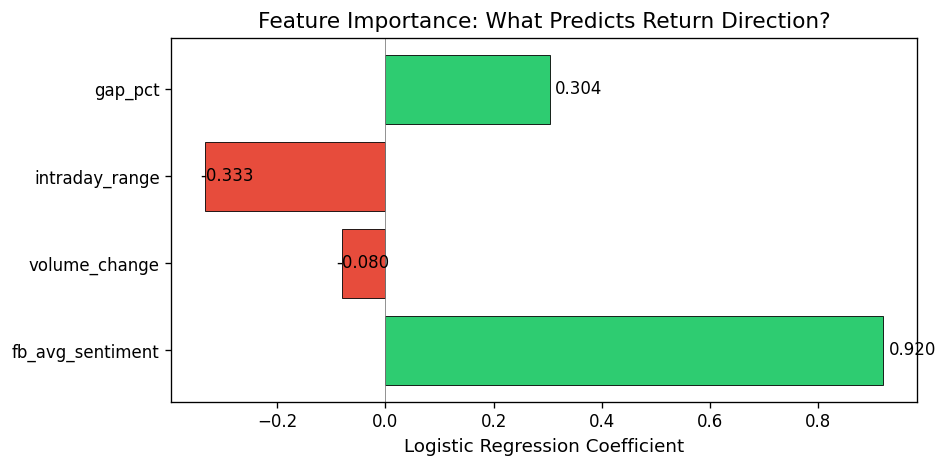

In [26]:
# --- Improvement C: Logistic Regression (sentiment + technicals) ---
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Build feature matrix from the fine-tuned merged data (has_news_ft = 19 rows)
FEATURES = ["fb_avg_sentiment", "volume_change", "intraday_range", "gap_pct"]
TARGET = "return_direction"

# Drop any rows with NaN in features or target
model_df = has_news_ft.dropna(subset=FEATURES + [TARGET]).copy()
X = model_df[FEATURES].values
y = model_df[TARGET].values.astype(int)

print(f"Model data: {len(model_df)} rows, {len(FEATURES)} features")
print(f"Class balance: Up={y.sum()}, Down={len(y)-y.sum()}")

# With only 19 samples, use Leave-One-Out cross-validation (most robust for small datasets)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

loo = LeaveOneOut()
y_pred_loo = cross_val_predict(
    LogisticRegression(random_state=42, max_iter=1000),
    X_scaled, y, cv=loo,
)

loo_accuracy = accuracy_score(y, y_pred_loo)

print(f"\n--- Logistic Regression (LOO-CV) ---")
print(f"  Direction accuracy : {loo_accuracy:.2%}")
print(f"  vs Sentiment-only  : {eval_results_ft['overall']['direction_accuracy']:.2%}")
print(f"  Improvement        : {loo_accuracy - eval_results_ft['overall']['direction_accuracy']:+.2%}")

print(f"\nClassification report:")
print(classification_report(y, y_pred_loo, target_names=["Down", "Up"]))

# Train final model on all data to see feature importance
lr_final = LogisticRegression(random_state=42, max_iter=1000)
lr_final.fit(X_scaled, y)

# Feature importance bar chart
fig, ax = plt.subplots(figsize=(8, 4))
coefs = lr_final.coef_[0]
colors = ["#2ecc71" if c > 0 else "#e74c3c" for c in coefs]
bars = ax.barh(FEATURES, coefs, color=colors, edgecolor="k", lw=0.5)
ax.set_xlabel("Logistic Regression Coefficient")
ax.set_title("Feature Importance: What Predicts Return Direction?")
ax.axvline(0, color="grey", lw=0.5)
for bar, c in zip(bars, coefs):
    ax.text(c + 0.01 * np.sign(c), bar.get_y() + bar.get_height()/2,
            f"{c:.3f}", va="center", fontsize=10)
fig.tight_layout()
plt.savefig(str(PROJECT_ROOT / "reports" / "figures" / "feature_importance.png"), dpi=150)
plt.show()

## 15 — Summary: All Improvements Compared

  IMPROVEMENT COMPARISON — All Methods
                                            n Pearson r Dir. Accuracy
Method                                                               
Baseline (pre fine-tune)                    5   -0.7485         20.0%
Fine-tuned FinBERT                         19   +0.1617         57.9%
A: + Confidence filter (≥0.7)              19   +0.1551         57.9%
B: + Rolling 3-day sentiment               19   +0.0530         52.6%
C: Logistic Regression (sentiment + tech)  19         —         52.6%


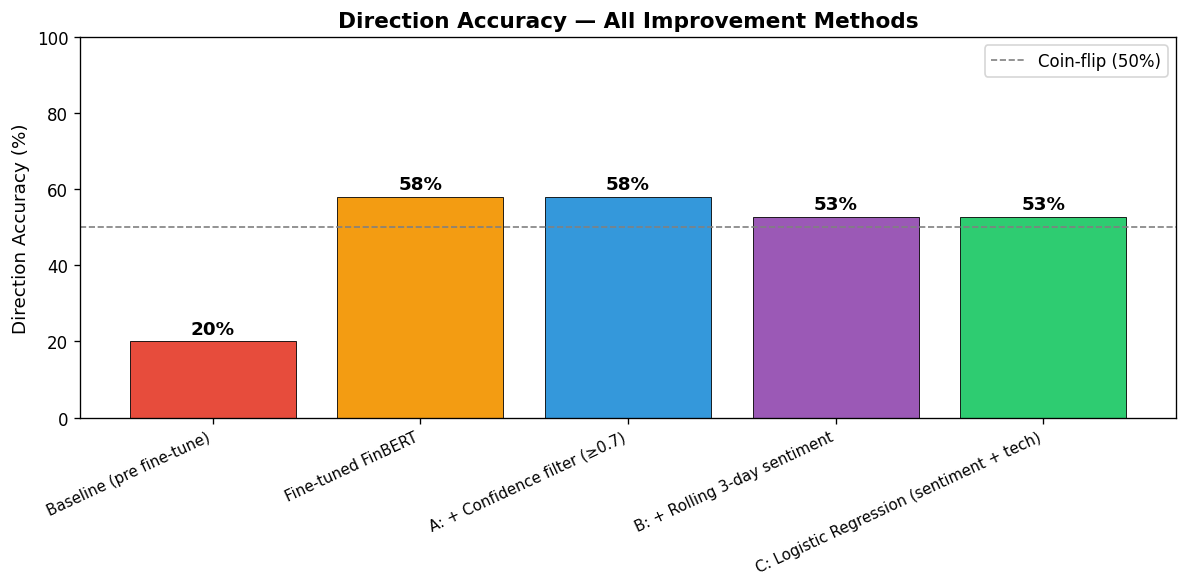


Best method: Fine-tuned FinBERT — 58% direction accuracy


In [27]:
# --- Summary comparison ---
summary_rows = [
    {
        "Method": "Baseline (pre fine-tune)",
        "n": eval_results["overall"]["n"],
        "Pearson r": eval_results["overall"]["pearson_r"],
        "Dir. Accuracy": eval_results["overall"]["direction_accuracy"],
    },
    {
        "Method": "Fine-tuned FinBERT",
        "n": eval_results_ft["overall"]["n"],
        "Pearson r": eval_results_ft["overall"]["pearson_r"],
        "Dir. Accuracy": eval_results_ft["overall"]["direction_accuracy"],
    },
    {
        "Method": f"A: + Confidence filter (≥{CONFIDENCE_THRESHOLD})",
        "n": eval_hc["overall"]["n"],
        "Pearson r": eval_hc["overall"]["pearson_r"],
        "Dir. Accuracy": eval_hc["overall"]["direction_accuracy"],
    },
    {
        "Method": f"B: + Rolling {ROLLING_WINDOW}-day sentiment",
        "n": eval_rolling["overall"]["n"],
        "Pearson r": eval_rolling["overall"]["pearson_r"],
        "Dir. Accuracy": eval_rolling["overall"]["direction_accuracy"],
    },
    {
        "Method": "C: Logistic Regression (sentiment + tech)",
        "n": len(model_df),
        "Pearson r": "—",
        "Dir. Accuracy": loo_accuracy,
    },
]

summary_df = pd.DataFrame(summary_rows).set_index("Method")
summary_df["Dir. Accuracy"] = summary_df["Dir. Accuracy"].apply(
    lambda x: f"{x:.1%}" if isinstance(x, (int, float)) else x
)
summary_df["Pearson r"] = summary_df["Pearson r"].apply(
    lambda x: f"{x:+.4f}" if isinstance(x, (int, float)) else x
)

print("=" * 70)
print("  IMPROVEMENT COMPARISON — All Methods")
print("=" * 70)
print(summary_df.to_string())
print("=" * 70)

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
methods = [r["Method"] for r in summary_rows]
accs = [r["Dir. Accuracy"] if isinstance(r["Dir. Accuracy"], (int, float)) else 0 for r in summary_rows]
colors = ["#e74c3c", "#f39c12", "#3498db", "#9b59b6", "#2ecc71"]
bars = ax.bar(range(len(methods)), [a * 100 for a in accs], color=colors, edgecolor="k", lw=0.5)

for bar, a in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{a:.0%}", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=25, ha="right", fontsize=9)
ax.set_ylabel("Direction Accuracy (%)")
ax.set_title("Direction Accuracy — All Improvement Methods", fontsize=13, fontweight="bold")
ax.axhline(50, color="grey", ls="--", lw=1, label="Coin-flip (50%)")
ax.legend()
ax.set_ylim(0, 100)
fig.tight_layout()
plt.savefig(str(PROJECT_ROOT / "reports" / "figures" / "improvement_comparison.png"), dpi=150)
plt.show()

# Best method
best_idx = max(range(len(accs)), key=lambda i: accs[i])
print(f"\nBest method: {methods[best_idx]} — {accs[best_idx]:.0%} direction accuracy")